In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from FRVRS import fu
from FRVRS import nu
import humanize
import matplotlib.pyplot as plt
import os
import os.path as osp
import re

PNG_PATH = '../saves/png'
os.makedirs(name=PNG_PATH, exist_ok=True)


# Fix Scenes with more than one SESSION_START

In [3]:

# Attempt to load the logs data frame
frvrs_logs_df = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df')['frvrs_logs_df']
print(frvrs_logs_df.shape)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
(829116, 114)


In [4]:

# Create a boolean mask to filter action types
start_stop_list = ['SESSION_END', 'SESSION_START']
actions_mask_series = frvrs_logs_df.action_type.isin(fu.responder_negotiations_list + start_stop_list)

# Include VOICE_COMMAND actions with specific messages in the mask
actions_mask_series |= ((frvrs_logs_df.action_type == 'VOICE_COMMAND') & (frvrs_logs_df.voice_command_message.isin(fu.command_messages_list)))

value_counts_df = frvrs_logs_df.groupby(['session_uuid', 'scene_id']).action_type.value_counts().to_frame().rename(
    columns={'action_type': 'type_count'}
).reset_index()
mask_series = (value_counts_df.action_type == 'SESSION_START') & (value_counts_df.type_count != 1)
value_counts_df[mask_series]

,session_uuid,scene_id,action_type,type_count
1921,1df10bfd-0f85-42ff-a873-36dfe05df77b,1,SESSION_START,2
7074,724fdf45-3165-43b8-b9ca-dc07102d2886,3,SESSION_START,2
9872,a0987257-801e-44c5-a1ad-81e0083bfa46,4,SESSION_START,2


Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/summary_statistics_df.pkl.


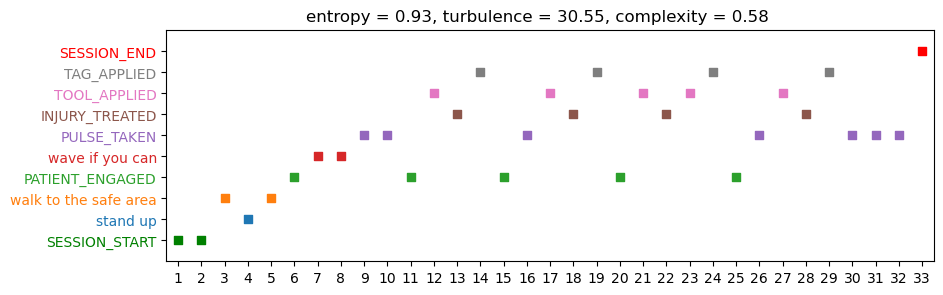

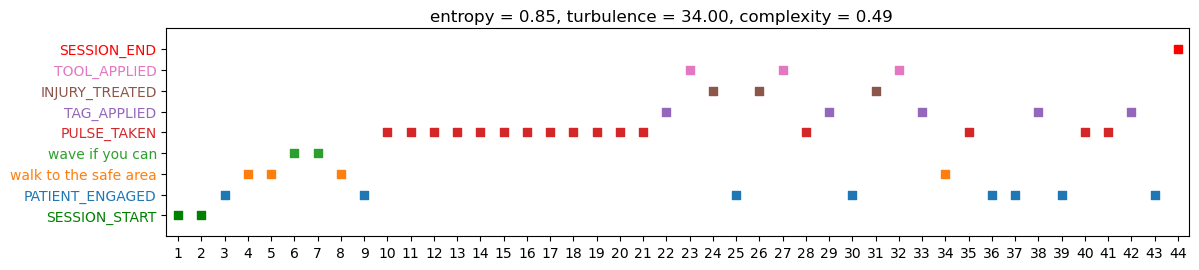

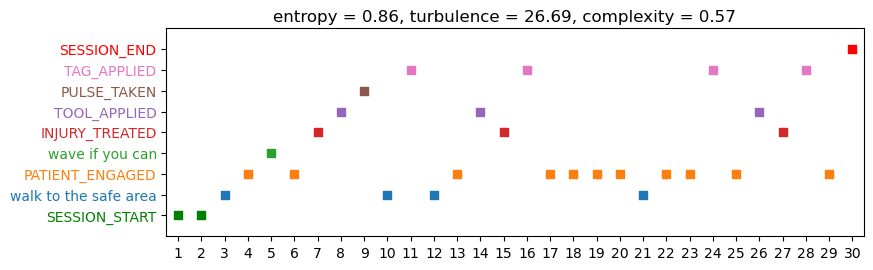

In [5]:

# Visualize all the scenes with the wrong number of session starts
time_groups_dict = nu.load_object('time_groups_dict')
summary_statistics_df = nu.load_data_frames(summary_statistics_df='summary_statistics_df')['summary_statistics_df']
for scene_tuple, scene_df in value_counts_df[mask_series].groupby(['session_uuid', 'scene_id']):
    sequence = time_groups_dict[scene_tuple]
    fig, ax = fu.plot_sequence_by_scene_tuple(
        scene_tuple, sequence, frvrs_logs_df, summary_statistics_df=summary_statistics_df,
        actions_mask_series=actions_mask_series, highlighted_ngrams=['SESSION_END', 'SESSION_START']
    )